In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import glob

import xarray as xr
import netCDF4
import cartopy
import cftime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pyproj


In [193]:
class PontdeVilomara:
    def __init__(self, filename):
        # Load the DataFrame
        self.df = pd.read_csv(filename, delimiter='\t', header=2)
        self.filename = filename

        # Extract latitude and longitude
        with open(filename, 'r') as file:
            first_line = file.readline().strip()
        data = first_line.split(' ')

        lat_lon = data[6]
        data2 = lat_lon.split(',')
        self.lat = float(data2[0])
        self.lon = float(data2[1])

        def get_lat(self):
            return self.lat

        def get_lon(self):
            return self.lon

        # Extract date
        with open(filename, 'r') as file:
            file.readline()  # Skip the first line
            second_line = file.readline().strip()
        data = second_line.split(' ')
        date = data[1]
        date_string = str(date)
        date_object = datetime.strptime(date_string, '%Y%m%d')
        self.date_only = date_object.date()

        # Define function to convert time range to datetime
        def convert_time_range_to_datetimes(time_range_str, date_str=self.date_only):
            start_time_str, end_time_str = time_range_str.split(' - ')
            start_datetime = datetime.strptime(f'{date_str} {start_time_str}', '%Y-%m-%d %H:%M')
            return pd.Series([start_datetime])
            

        # Apply the function to the DataFrame
        self.df[['date', ]] = self.df['Periode[UTM]'].apply(lambda x: pd.Series(convert_time_range_to_datetimes(x)))
        self.df.drop(columns=['Periode[UTM]'], inplace=True) 

In [194]:
stationame = 'CastellouDeBages'

# Use glob to get all matching filenames
filenames = sorted(glob.glob(f'/data/IMFSE/PythonCourse/PontdeVilomara/WeatherStations/wx*{stationame}.csv'))

# Create instances for each file and collect DataFrames
pdVWs = []
for filename in filenames:
    pdVWs_ = PontdeVilomara(filename)
    lat = pdVWs_.lat
    lon = pdVWs_.lon

    pdVWs.append(pdVWs_.df)

# Concatenate DataFrames from all instances
obs = pd.concat(pdVWs, ignore_index=True)

# Display the concatenated DataFrame
#concatenated_df


In [195]:
obs = obs.rename(columns={'date': 'time', ' VVX10m[km/h]': 'gust10'})

In [196]:
obs = obs.set_index('time')

In [197]:
obs

,TM[C],TX[C],TN[C],HRM[%],PPT[mm],VVM10m[km/h],DVM10m[graus],gust10,RS[W/m2]
time,,,,,,,,,
2022-07-16 00:00:00,24.4,24.7,24.1,43,0.0,4.7,27,12.2,0
2022-07-16 00:30:00,23.7,24.7,22.8,46,0.0,7.9,36,11.9,0
2022-07-16 01:00:00,22.6,22.9,22.3,49,0.0,5.4,21,11.9,0
2022-07-16 01:30:00,23.1,23.3,22.9,48,0.0,5.0,20,11.2,0
2022-07-16 02:00:00,22.5,22.9,22.3,50,0.0,6.1,11,10.8,0
...,...,...,...,...,...,...,...,...,...
2022-07-17 21:30:00,25.2,25.7,24.6,38,0.0,2.2,346,4.3,0
2022-07-17 22:00:00,24.8,25.3,24.0,39,0.0,1.8,352,4.0,0
2022-07-17 22:30:00,24.3,24.8,23.8,40,0.0,3.2,310,4.3,0


In [180]:
def extractWsFromModel(fileinput, wslat,wslon):
    ds = xr.open_dataset(fileinput, decode_times=False)
    # Extract the time variable
    time_var = ds["time"]

    # Get the time units, and remove the non-standard prefix
    units = time_var.attrs['units'].replace('fire ignition: ', '')

    # Convert the time variable using cftime
    times = cftime.num2date(time_var.values, units=units, calendar='standard')

    # Convert to pandas datetime if needed
    times_as_datetime = [datetime(year=t.year, month=t.month, day=t.day, 
                              hour=t.hour, minute=t.minute, second=t.second,microsecond=t.microsecond)
                     for t in times]


    # Replace the time variable in the dataset with the converted times
    ds["time"] = ("time", times_as_datetime)

    lat = ds['lat'].values[:,0]
    lon = ds['lon'].values[0,:]

    # Calculate the absolute differences between the werather stations coordinates and the grid points
    idx_lat = np.abs(lat - wslat).argmin()
    idx_lon = np.abs(lon - wslon).argmin()

    df = ds.isel(x=idx_lon,y=idx_lat)[['um10','vm10','t2m','gust10']].to_dataframe()

    df['wdir'] = (np.arctan2(df['um10'], df['vm10']) * 180 / np.pi + 360) % 360

    df['wspeed'] = np.sqrt(df['um10']**2 + df['vm10']**2)

    return df.drop(columns=['x','y'])

In [181]:
fileinput = '/data/IMFSE/PythonCourse/MNH/FCAST_model3.nc'
ds = xr.open_dataset(fileinput, decode_times=False)

In [182]:
ds

<xarray.Dataset> Size: 7GB
Dimensions:       (x: 150, y: 150, z: 50, time: 49)
Coordinates:
  * x             (x) float32 600B 5.344e+04 5.352e+04 ... 6.528e+04 6.536e+04
  * y             (y) float32 600B 7.344e+04 7.352e+04 ... 8.528e+04 8.536e+04
  * z             (z) float32 200B 15.0 46.5 81.15 ... 1.736e+04 1.826e+04
  * time          (time) float64 392B 0.0 3.6e+03 ... 1.692e+05 1.728e+05
Data variables: (12/31)
    lat           (y, x) float64 180kB ...
    lon           (y, x) float64 180kB ...
    dx            (z, y, x) float64 9MB ...
    dy            (z, y, x) float64 9MB ...
    dz            (z, y, x) float64 9MB ...
    topography    (y, x) float64 180kB ...
    ...            ...
    vm10          (time, y, x) float64 9MB ...
    gust10        (time, y, x) float64 9MB ...
    lambda2       (time, z, y, x) float64 441MB ...
    acprecip      (time, z, y, x) float64 441MB ...
    cloudfrac     (time, z, y, x) float64 441MB ...
    t2m           (time, y, x) float64 9MB ...
Attributes:
    description:  MNH Output for simulation FCAST and model3
    created:      R. Paugam
    company:      DoWeNeedOne
    title:        MNH Output

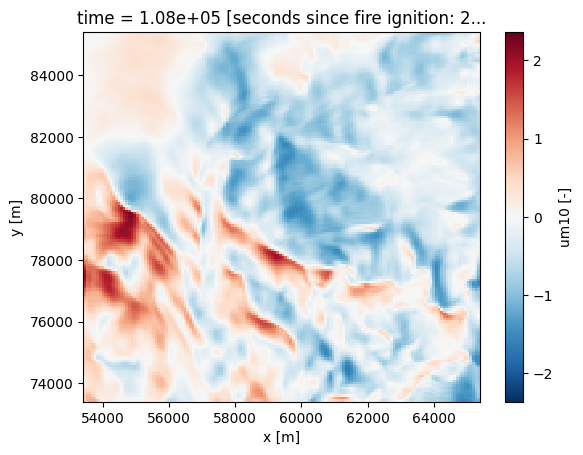

In [183]:
ds.um10.isel(time=30).plot()

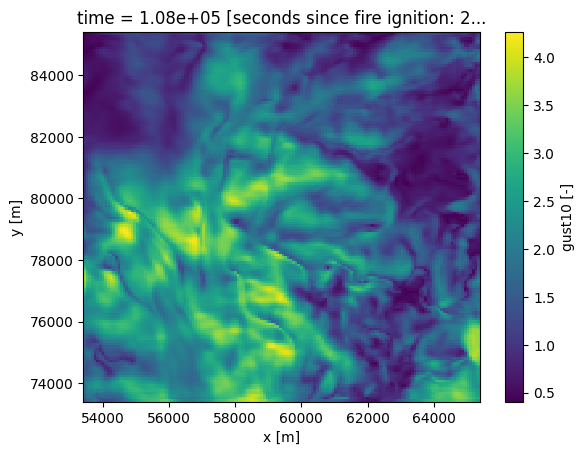

In [184]:
ds.gust10.isel(time=30).plot()

In [198]:
fileinput = '/data/IMFSE/PythonCourse/MNH/FCAST_model3.nc'

# Coordinates of the weather stations
wslat = lat
wslon = lon

model = extractWsFromModel(fileinput, wslat,wslon)

In [199]:
model

,um10,vm10,t2m,gust10,wdir,wspeed
time,,,,,,
2022-07-16 00:00:00,0.284463,-0.454374,1.000000e+20,0.936074,147.951146,0.536074
2022-07-16 01:00:00,-0.657117,-0.278774,1.000000e+20,1.113805,247.011516,0.713805
2022-07-16 02:00:00,-0.252196,-0.282423,1.000000e+20,0.778636,221.763988,0.378636
2022-07-16 03:00:00,-0.507731,-0.888757,1.000000e+20,1.423562,209.738534,1.023562
2022-07-16 04:00:00,-0.693409,-0.248774,1.000000e+20,1.192280,250.263559,0.736684
2022-07-16 05:00:00,0.270433,-0.094160,1.000000e+20,0.717645,109.197153,0.286357
2022-07-16 06:00:00,-0.117394,0.086022,1.000000e+20,0.742919,306.232475,0.145538
2022-07-16 07:00:00,-0.454005,0.059391,1.000000e+20,1.747353,277.452910,0.457873
2022-07-16 08:00:00,-0.597392,-0.165096,1.000000e+20,2.437446,254.551313,0.619785


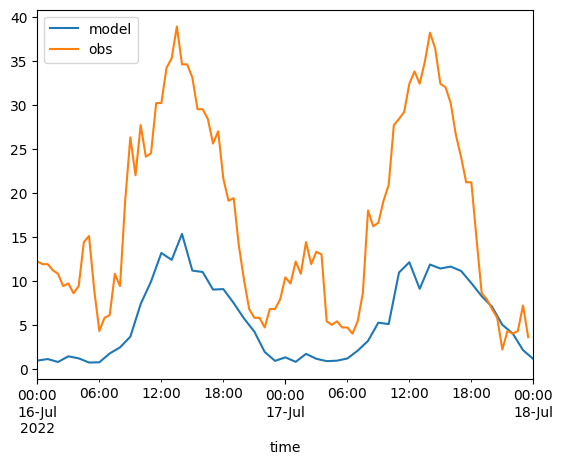

In [200]:
model['gust10'].plot(label='model')
obs['gust10'].plot(label='obs')
plt.legend()

In [201]:
obs.keys()

Index(['TM[C]', ' TX[C]', ' TN[C]', 'HRM[%]', 'PPT[mm]', 'VVM10m[km/h] ',
       'DVM10m[graus]', 'gust10', ' RS[W/m2]'],
      dtype='object')

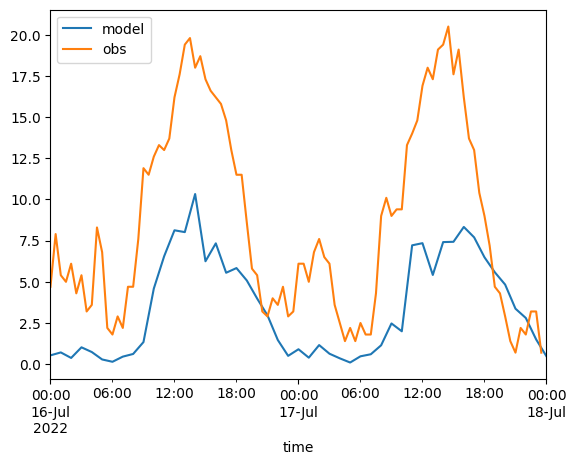

In [202]:
model['wspeed'].plot(label='model')
obs['VVM10m[km/h] '].plot(label='obs')
plt.legend()

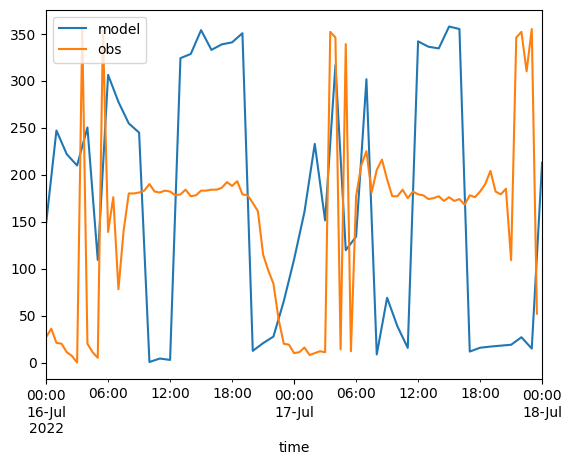

In [203]:
model['wdir'].plot(label='model')
obs['DVM10m[graus]'].plot(label='obs')
plt.legend()

<Axes: xlabel='time'>

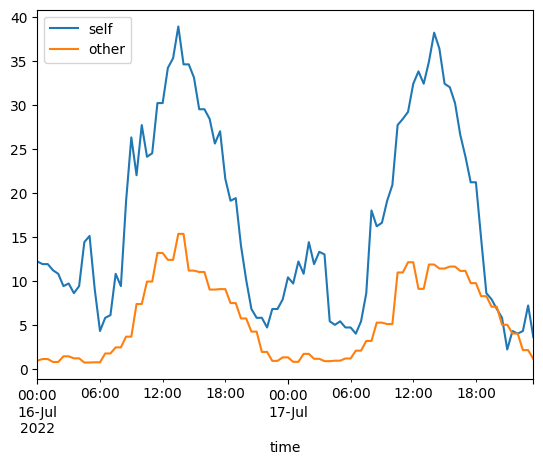

In [204]:
df1 = obs
df2 = model
# Example DataFrames

# Set 'time' as the index for both DataFrames
#df1.set_index('time', inplace=True)
#df2.set_index('time', inplace=True)

# Reindex df2 to the time indices of df1
df2_resampled = df2.reindex(df1.index, method='nearest')

# Now you can compare or perform any operation
comparison = df1['gust10'].compare(df2_resampled['gust10'])


comparison.plot()